# Visualizing CNN Saliency Maps

Saliency Map is another technique to visualize what neural network layers learn. By Wikipedia, a <a href="https://en.wikipedia.org/wiki/Saliency_map"> saliency map </a> is an image that shows each pixel's unique quality, be it colr, intensity or etc. The goal of a saliency map is to simplified and/or change the representation of an image into something that is more meaningful and easier to analyze.   

In our context, we construct saliency maps through back-propagation, each pixel is the gradient of the neuron activation in a forward pass with respect to the original image pixel of the same position. Then the saliency map will indicate how each pixel affects the corresponding neuron activation (or think of the relative importance of each pixel to that neuron activation), hence giving a clue of what it learns in training. Concretely, saliency map for a neuron that recognizes a circle will highlight the corresponding circular section, since the pixels there represent relatively large gradients. 

<img src="image/saliency_example.jpeg">  

<p align="center"> image credits to http://emotion-research.net/Members/PhilippeGuillotel/copy_of_saliencymap.JPG/view</p>

## Original image (example)

Preprocess the image: resize to the input dimension specified by our VGG16 model and convert to Numpy arrays for tensor calculations. 

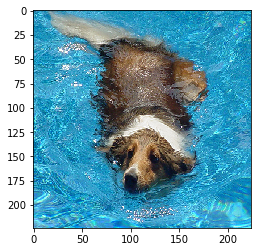

In [13]:
img_path = 'image/doginwater.jpg'
# must resize the original image since we include fully-connected layers in the model wth input size constraints
img = image.load_img(img_path, target_size=(224, 224))   
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

plt.imshow(img)

## Saliency map 

The VGG16 model we create includes the top fully-connected layers since we will need the predicted class score to conduct back-propagation.   

However, the last fuly-connected layer uses a softmax activation which squeezes the predicted score to a [0, 1] scale. Since unnormalized scores are sufficient to make a prediction, we want to save the trouble of adding an extra layer (due to overhead in feed-forward and back-propagation).   

In the follwing, we will remove the softmax layer and demonstrate how VGG16 is implemented in Keras along the way (refer to https://github.com/fchollet/keras/blob/master/keras/applications/vgg16.py for source code).

In [14]:
from keras.models import Sequential
from keras.layers import InputLayer, Conv2D, MaxPooling2D, Flatten, Dense

# create TensorFlow placeholder to hold image input 
input_img = tf.placeholder(tf.float32, shape=(None, 224, 224, 3))

### VGG16 in Keras (no softmax)

<img src="image/vgg16.png">
<p align="center">image credits to Heuritech Le Blog https://blog.heuritech.com/2016/02/29/a-brief-report-of-the-heuritech-deep-learning-meetup-5/</p>

In [15]:
model = Sequential()

# link the input placeholder to model input
model.add(InputLayer(input_tensor=input_img,
                     input_shape=(None, 224, 224, 3)))

# Block 1
model.add(Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1'))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2'))
model.add(MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool'))

# Block 2
model.add(Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2'))
model.add(MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool'))

# Block 3
model.add(Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1'))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2'))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv3'))
model.add(MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool'))

# Block 4
model.add(Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1'))
model.add(Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2'))
model.add(Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv3'))
model.add(MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool'))

# Block 5
model.add(Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv1'))
model.add(Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv2'))
model.add(Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv3'))
model.add(MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool'))

# FCs 
model.add(Flatten(name='flatten'))
model.add(Dense(4096, activation='relu', name='fc1'))
model.add(Dense(4096, activation='relu', name='fc2'))

# linear activation f(x)=x, output unnormalized predicted scores, no softmax
model.add(Dense(1000, activation='linear', name='predictions'))    

# retrieve model output for gradient computations
output_tensor = model.output

### Keras backend

Create a Tensorflow session and register it as default in Keras backend. 

In [16]:
from keras import backend as K

sess = tf.Session()
K.set_session(sess)

In [17]:
init_op = tf.global_variables_initializer()
sess.run(init_op)

*** Attention ***: initialize variables before loading pretrained weights, otherwise they will be overwritten. 

In [18]:
from keras.utils.data_utils import get_file

WEIGHTS_PATH = 'https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg16_weights_tf_dim_ordering_tf_kernels.h5'
weights_path = get_file('vgg16_weights_tf_dim_ordering_tf_kernels.h5', WEIGHTS_PATH, cache_subdir='models')

model.load_weights(weights_path)

### Define loss function (predicted class score) 

In [19]:
index = np.argmax(output_tensor[0])
loss = output_tensor[0][index]

### Define gradient operation 

In [20]:
# compute the gradient of the input picture with respect to this loss
grads = K.gradients(loss, input_img)[0]

# normalization trick: we normalize the gradient
grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

### Compute !

In [24]:
# with sess.as_default():
#     res, saliency_map = sess.run([output_tensor, grads], feed_dict={input_img: x})

saliency_map = grads()
    
print(saliency_map.shape)    # validate saliency map result (by matching dimensions (1, 224, 224, 3)) 
                            #  specifically, batch size 1, input image size 224 x 224, channels size 3 -> make sense!

(1, 224, 224, 3)


## Visualization

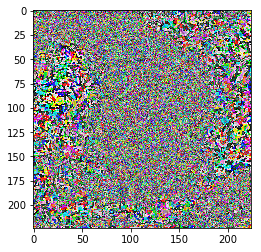

In [25]:
# plot saliency map of the first image instance 
plt.imshow(saliency_map[0])

The resulting saliency map is blurry and noisy, only a rough outline of the main object can be seen.

### Augment saliency map 

In [ ]:
from scipy.misc import imsave

# util function to convert a tensor into a valid image
def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5    # center to 0.5 for the [0, 1] interval
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    if K.image_data_format() == 'channels_first':
        x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x

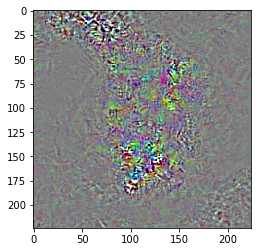

In [23]:
img = saliency_map[0]
img = deprocess_image(img)

plt.imshow(img)

### Evaluation 

By standardizing and rescaling the gradient values to the RGB pixel range [0, 255], the saliency map shows clearer boundaries, which match with the corresponding object in the image. Other image augmentation tricks can be used to get a better result, you are welcome to explore in depth.  

Saliency map represents portion of the image which affects the defined loss the most (essentially it quantifies the importance of each pixel to the loss function). From this point of view, saliency maps can also be used in image segmentation with the help of other computer vision techniques as the following. 

<img src="image/saliency_map_image_segmentation.JPG", width=600>
<p align="center">image credits to CS231n Lecture 12 Visualizing and Understanding http://cs231n.stanford.edu/slides/2017/cs231n_2017_lecture12.pdf </p>